# KG Build up Initial try
#### Reference: https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [4]:
import spacy

# OSError Solution
# Reference: https://github.com/explosion/spaCy/issues/4577
# pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [5]:
doc = nlp("Nagal won the first set.")

# To extract the relation, we have to find the ROOT of the sentence.
# (which is also the verb of the sentence)
# Hence, the relation extracted from this sentence would be “won”.
for tok in doc:
    print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [6]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

C:\Users\ricardo\Anaconda3\envs\normal\lib\site-packages\spacy\util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("./datasets/wiki_sentences_v2.csv")
candidate_sentences.shape
print(candidate_sentences.head(), '\n')
print(candidate_sentences['sentence'].sample(5))

                                                       sentence
0  confused and frustrated, connie decides to leave on her own.
1             later, a woman’s scream is heard in the distance.
2                      christian is then paralyzed by an elder.
3                                    the temple is set on fire.
4                             outside, the cult wails with him. 

548                                                                                                         such films include silver streak, dr.
3518    ali wong, steven williams, derek wilson, dana lee, françois chau, matthew willig, and robert catrini have been cast in undisclosed roles.
3024                                                          after mcquarrie's drawings for lucas's colleagues hal barwood and matthew robbins  
1970                                                      similarly, james dean and his brief film career have become icons of alienated youth.  
1981                          

In [12]:
doc = nlp("the drawdown process is governed by astm standard d823")

# Perfect! There is only one subject (‘process’) and only one object (‘standard’). 
# You can check for other sentences in a similar manner.
for tok in doc:
    print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [14]:
def get_entities(sent):
#     chunk 1
#     I have defined a few empty variables in this chunk. 
#     prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word 
#     in the sentence and that previous word itself, respectively. 
#     prefix and modifier will hold the text that is associated with the subject or the object.
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""        # dependency tag of previous token in the sentence
    prv_tok_text = ""     # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
    
    for tok in nlp(sent):
#         chunk 2
#         Next, we will loop through the tokens in the sentence. 
#         We will first check if the token is a punctuation mark or not. 
#         If yes, then we will ignore it and move on to the next token. 
#         If the token is a part of a compound word (dependency tag = “compound”), 
#         we will keep it in the prefix variable. 
#         A compound word is a combination of multiple words linked to form a word 
#         with a new meaning (example – “Football Stadium”, “animal lover”).
#         As and when we come across a subject or an object in the sentence, 
#         we will add this prefix to it. 
#         We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
            
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
#             chunk 3
#             Here, if the token is the subject, 
#             then it will be captured as the first entity in the ent1 variable. 
#             Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""            

#             chunk4
#             Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. 
#             Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
                
#             chunk 5
#             Once we have captured the subject and the object in the sentence, 
#             we will update the previous token and its dependency tag.  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [16]:
# Test of the function
get_entities("the film had 200 patents")

['film', '200  patents']

In [17]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:32<00:00, 131.06it/s]


In [18]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'selene  gallio'],
 ['singer', 'sequel']]

# Relation / Predicate Extraction

In [19]:
def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
                        {'DEP':'prep','OP':"?"},
                        {'DEP':'agent','OP':"?"},    
                        {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)

In [20]:
get_relation("John completed the task")

'completed'

In [21]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:31<00:00, 135.87it/s]


In [22]:
pd.Series(relations).value_counts()[:50]

is               371
was              297
released on       92
are               74
include           73
were              65
released          40
composed by       35
's                34
have              31
became            30
has               30
become            28
released in       27
included          26
produced          22
called            22
been              21
had               20
considered        20
made              20
be                18
stars             18
scheduled         17
directed by       16
used              16
received          15
written by        15
set               14
hired             14
wrote             13
went              13
introduced in     13
produced by       13
wanted            12
sold              12
began             11
began in          11
cast as           11
won               11
features          10
gave              10
includes          10
directed           9
produced in        9
shot in            9
opened             9
said         

# Build a Knowledge Graph

In [42]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

# kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df = pd.DataFrame({'source':source[:500], 'target':target[:500], 'edge':relations[:500]})

# kg_df.to_csv('./temp.csv', sep=',', encoding='utf8')

In [43]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

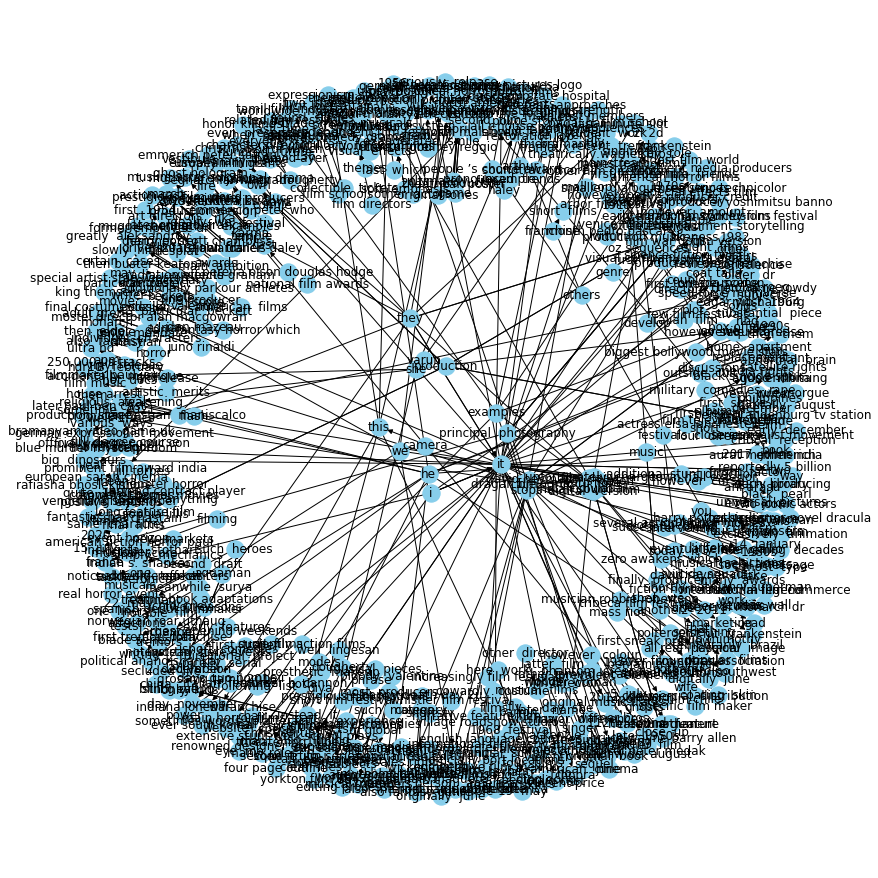

In [44]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()